In [ ]:
import os
import pandas as pd
import jieba
import re
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
import logging

# --- 配置区 ---
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

custom_stopwords = ["豆包", "DS", "下载", "文心", "百度", "一言", "内容", "东西", "偷笑", "感觉", "真的", "模型", "女套",
                    "男套", "玫瑰", "捂脸", "哈哈", "排位", "正赛", "量子", "男鞋", "雷诺", "男裤", "永久", "哈", "哈哈哈", "哈哈哈哈",]
STOPWORDS_PATH = "stopwords1893.txt"

save_dir = "E:"
platforms = ['dy', 'xhs', 'tieba']
comment_column = 'content'
k_range = range(2, 13)  # 2到12

# 加载停用词
def load_chinese_stopwords(filepath, custom_list):
    stopwords = set(custom_list)
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip()
                if word:
                    stopwords.add(word)
        print(f"成功从 '{filepath}' 加载 {len(stopwords) - len(custom_list)} 个标准停用词。")
    except FileNotFoundError:
        print(f"警告: 标准停用词文件未找到: '{filepath}'。仅使用自定义停用词。")
    except Exception as e:
        print(f"加载停用词文件 '{filepath}' 时出错: {e}。仅使用自定义停用词。")
    print(f"总停用词数量: {len(stopwords)}")
    return stopwords

# 文本预处理
def preprocess_text(text, stop_words_set):
    if not isinstance(text, str):
        return []
    text = re.sub(r"http[s]?://\S+", "", text)
    text = re.sub(r"[^\u4e00-\u9fa5]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    if not text:
        return []
    words = jieba.lcut(text)
    words = [word for word in words if word not in stop_words_set and len(word) > 1]
    return words

# 计算LDA各种分数
def compute_lda_metrics(corpus, dictionary, texts, k_values):
    perplexity_scores = []
    coherence_c_v_scores = []
    coherence_u_mass_scores = []
    print(f"开始计算主题数 k 从 {min(k_values)} 到 {max(k_values)} 的困惑度和一致性...")

    for k in k_values:
        print(f"  正在计算 k = {k}...")
        try:
            lda_model = models.LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=k,
                random_state=42,
                passes=10,
                alpha='auto',
                eta='auto',
                eval_every=None
            )
            log_perplexity = lda_model.log_perplexity(corpus)
            perplexity_scores.append(log_perplexity)

            # C_v
            coherence_model_cv = CoherenceModel(
                model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v'
            )
            coherence_c_v = coherence_model_cv.get_coherence()
            coherence_c_v_scores.append(coherence_c_v)

            # U_Mass
            coherence_model_umass = CoherenceModel(
                model=lda_model, texts=texts, dictionary=dictionary, coherence='u_mass'
            )
            coherence_u_mass = coherence_model_umass.get_coherence()
            coherence_u_mass_scores.append(coherence_u_mass)

            print(f"    k={k}: Log Perplexity = {log_perplexity:.4f}, "
                  f"C_v = {coherence_c_v:.4f}, U_Mass = {coherence_u_mass:.4f}")

        except Exception as e:
            print(f"  计算 k = {k} 时出错: {e}")
            perplexity_scores.append(None)
            coherence_c_v_scores.append(None)
            coherence_u_mass_scores.append(None)
            continue

    return perplexity_scores, coherence_c_v_scores, coherence_u_mass_scores

def plot_metrics(k_values, coherence_c_v_scores, coherence_u_mass_scores, platform_name):
    valid_indices = [i for i, (c_v, u_mass) in enumerate(zip(coherence_c_v_scores, coherence_u_mass_scores)) if c_v is not None and u_mass is not None]
    if not valid_indices:
        print(f"平台 {platform_name}: 没有有效分数，无法绘图。")
        return
    k_valid = [k_values[i] for i in valid_indices]
    c_v_valid = [coherence_c_v_scores[i] for i in valid_indices]
    u_mass_valid = [coherence_u_mass_scores[i] for i in valid_indices]

    plt.figure(figsize=(10, 5))
    plt.plot(k_valid, c_v_valid, marker='o', linestyle='-', label='Coherence C_v')
    plt.plot(k_valid, u_mass_valid, marker='s', linestyle='--', label='Coherence U_Mass')
    plt.xlabel('主题数K')
    plt.ylabel('一致性分数')
    plt.title(f"{platform_name} LDA主题模型一致性对比")
    plt.legend()
    plt.grid(True)
    plt.xticks(k_valid)
    plt.show()

if __name__ == "__main__":
    jieba.setLogLevel(logging.ERROR)
    print("正在加载停用词...")
    stop_words = load_chinese_stopwords(STOPWORDS_PATH, custom_stopwords)
    platform_results = {}

    for platform in platforms:
        print(f"\n{'='*20} 开始处理平台: {platform} {'='*20}")
        file_path = os.path.join(save_dir, f"{platform}_combined.csv")
        try:
            print(f"正在加载数据文件: {file_path}")
            df = pd.read_csv(file_path, encoding='utf-8')
            print(f"成功加载数据，共 {len(df)} 条记录。")
            if comment_column not in df.columns:
                print(f"错误: 未找到评论列 '{comment_column}'。跳过。")
                continue
            df.dropna(subset=[comment_column], inplace=True)
            if df.empty:
                print(f"错误: {file_path} 去除空值后无数据。跳过。")
                continue
            texts_original = df[comment_column].tolist()
        except Exception as e:
            print(f"加载文件出错: {e}，跳过。")
            continue

        print("开始进行文本预处理...")
        processed_texts = [preprocess_text(text, stop_words) for text in texts_original]
        processed_texts = [doc for doc in processed_texts if doc]
        if not processed_texts:
            print(f"警告: {platform} 预处理后无有效文本。跳过。")
            continue
        print(f"文本预处理完成，有效文档数量: {len(processed_texts)}")

        print("正在创建字典和语料库...")
        try:
            dictionary = corpora.Dictionary(processed_texts)
            dictionary.filter_extremes(no_below=5, no_above=0.6, keep_n=100000)
            dictionary.compactify()
            if not dictionary:
                print(f"警告: {platform} 过滤后字典为空。跳过。")
                continue
            corpus = [dictionary.doc2bow(text) for text in processed_texts]
            corpus = [bow for bow in corpus if bow]
            if not corpus:
                print(f"警告: {platform} 语料库为空。跳过。")
                continue
            print(f"字典和语料库创建完成。字典大小: {len(dictionary)}, 文档数: {len(corpus)}")
        except Exception as e:
            print(f"创建字典或语料库出错: {e}，跳过。")
            continue

        # 计算困惑度和一致性
        perplexity_values, coherence_c_v_values, coherence_u_mass_values = compute_lda_metrics(
            corpus, dictionary, processed_texts, list(k_range)
        )

        platform_results[platform] = {
            'dictionary': dictionary,
            'corpus': corpus,
            'processed_texts': processed_texts,
            'k_values': list(k_range),
            'perplexity': perplexity_values,
            'coherence_c_v': coherence_c_v_values,
            'coherence_u_mass': coherence_u_mass_values
        }

        # 输出C_v和U_Mass表格
        print(f"\n平台 {platform} 的LDA一致性指标 (主题数K=2-12):")
        print("K\tC_v\t\tU_Mass")
        for k, c_v, u_mass in zip(list(k_range), coherence_c_v_values, coherence_u_mass_values):
            c_v_str = f"{c_v:.4f}" if c_v is not None else "None"
            u_mass_str = f"{u_mass:.4f}" if u_mass is not None else "None"
            print(f"{k}\t{c_v_str}\t{u_mass_str}")

        # 可视化
        plot_metrics(list(k_range), coherence_c_v_values, coherence_u_mass_values, platform)

    print("\n所有平台处理完毕。")


In [5]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

def save_lda_vis_html(platform, dictionary, corpus, processed_texts, k):
    # 重新训练LDA（让你自己选主题数k）
    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        passes=20,
        iterations=400,
        alpha='auto',
        eta='auto',
        eval_every=None
    )
    # 生成PyLDAvis数据
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    # 保存为html文件
    save_path = os.path.join( f"{platform}_lda_k{k}_pyldavis.html")
    pyLDAvis.save_html(vis, save_path)
    print(f"PyLDAvis交互页面已保存至：{save_path}")

# 示例用法（假设你已选择平台、主题数k、已得dictionary/corpus/processed_texts）
save_lda_vis_html('xhs', dictionary, corpus, processed_texts, k=5)


PyLDAvis交互页面已保存至：xhs_lda_k5_pyldavis.html



==================== 开始处理平台: dy ====================

dy: 正在计算BERTopic主题数=2
k=2: C_v=0.4654, U_Mass=0.0000

dy: 正在计算BERTopic主题数=3
k=3: C_v=0.7140, U_Mass=-0.0876

dy: 正在计算BERTopic主题数=4
k=4: C_v=0.6851, U_Mass=-0.1788

dy: 正在计算BERTopic主题数=5
k=5: C_v=0.6599, U_Mass=-0.1539

dy: 正在计算BERTopic主题数=6
k=6: C_v=0.5725, U_Mass=-0.2950

dy: 正在计算BERTopic主题数=7
k=7: C_v=0.5820, U_Mass=-0.2953

dy: 正在计算BERTopic主题数=8
k=8: C_v=0.6427, U_Mass=-0.3171

dy: 正在计算BERTopic主题数=9
k=9: C_v=0.6128, U_Mass=-0.3495

dy: 正在计算BERTopic主题数=10
k=10: C_v=0.6273, U_Mass=-0.2790

dy: 正在计算BERTopic主题数=11
k=11: C_v=0.6497, U_Mass=-0.3365

dy: 正在计算BERTopic主题数=12
k=12: C_v=0.6061, U_Mass=-0.3519

平台 dy BERTopic一致性得分表：
K	C_v		U_Mass
2	0.4654	0.0000
3	0.7140	-0.0876
4	0.6851	-0.1788
5	0.6599	-0.1539
6	0.5725	-0.2950
7	0.5820	-0.2953
8	0.6427	-0.3171
9	0.6128	-0.3495
10	0.6273	-0.2790
11	0.6497	-0.3365
12	0.6061	-0.3519


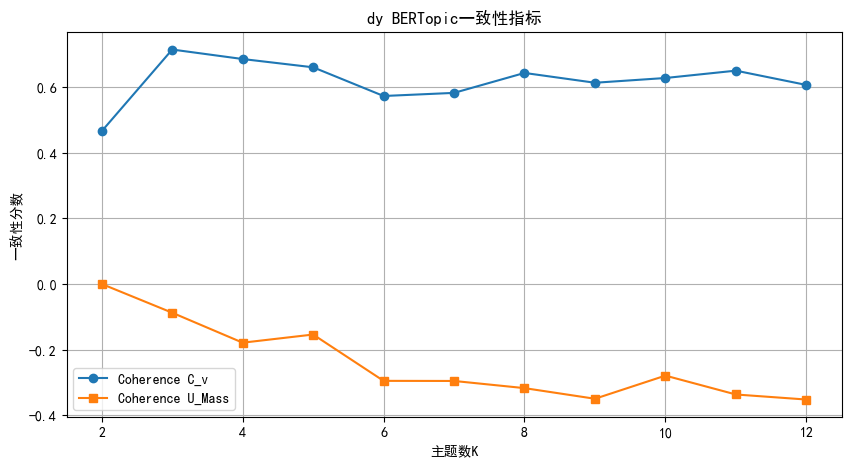


==================== 开始处理平台: xhs ====================

xhs: 正在计算BERTopic主题数=2
k=2: C_v=0.6861, U_Mass=0.0000

xhs: 正在计算BERTopic主题数=3
k=3: C_v=0.5911, U_Mass=-0.0164

xhs: 正在计算BERTopic主题数=4
k=4: C_v=0.3725, U_Mass=-0.0401

xhs: 正在计算BERTopic主题数=5
k=5: C_v=0.5862, U_Mass=-0.1010

xhs: 正在计算BERTopic主题数=6
k=6: C_v=0.7132, U_Mass=-0.1290

xhs: 正在计算BERTopic主题数=7
k=7: C_v=0.5086, U_Mass=-0.1692

xhs: 正在计算BERTopic主题数=8
k=8: C_v=0.6185, U_Mass=-0.2837

xhs: 正在计算BERTopic主题数=9
k=9: C_v=0.5922, U_Mass=-0.3143

xhs: 正在计算BERTopic主题数=10
k=10: C_v=0.5447, U_Mass=-0.3120

xhs: 正在计算BERTopic主题数=11
k=11: C_v=0.5686, U_Mass=-0.3424

xhs: 正在计算BERTopic主题数=12
k=12: C_v=0.5557, U_Mass=-0.3577

平台 xhs BERTopic一致性得分表：
K	C_v		U_Mass
2	0.6861	0.0000
3	0.5911	-0.0164
4	0.3725	-0.0401
5	0.5862	-0.1010
6	0.7132	-0.1290
7	0.5086	-0.1692
8	0.6185	-0.2837
9	0.5922	-0.3143
10	0.5447	-0.3120
11	0.5686	-0.3424
12	0.5557	-0.3577


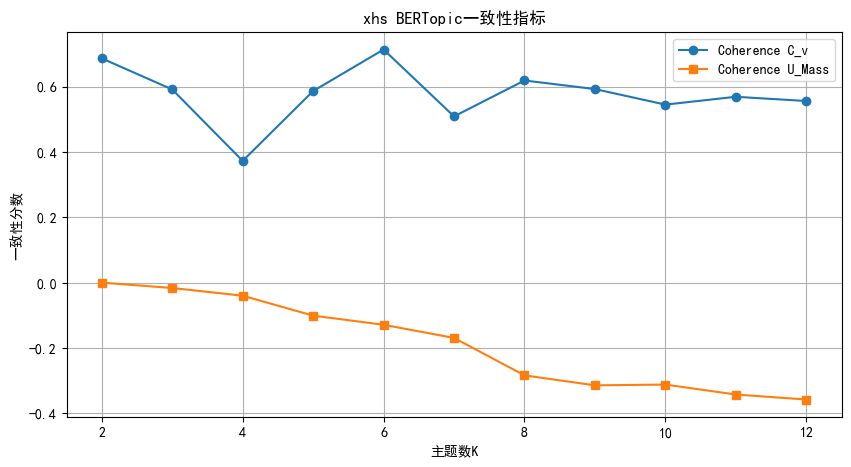


==================== 开始处理平台: tieba ====================

tieba: 正在计算BERTopic主题数=2
k=2: C_v=0.6204, U_Mass=0.0000

tieba: 正在计算BERTopic主题数=3
k=3: C_v=0.2976, U_Mass=-0.0128

tieba: 正在计算BERTopic主题数=4
k=4: C_v=0.4710, U_Mass=-0.0717

tieba: 正在计算BERTopic主题数=5
k=5: C_v=0.5944, U_Mass=-0.2821

tieba: 正在计算BERTopic主题数=6
k=6: C_v=0.6381, U_Mass=-0.2722

tieba: 正在计算BERTopic主题数=7
k=7: C_v=0.6401, U_Mass=-0.2885

tieba: 正在计算BERTopic主题数=8
k=8: C_v=0.5374, U_Mass=-0.2813

tieba: 正在计算BERTopic主题数=9
k=9: C_v=0.5830, U_Mass=-0.3675

tieba: 正在计算BERTopic主题数=10
k=10: C_v=0.5912, U_Mass=-0.3941

tieba: 正在计算BERTopic主题数=11
k=11: C_v=0.5366, U_Mass=-0.3718

tieba: 正在计算BERTopic主题数=12
k=12: C_v=0.5731, U_Mass=-0.4778

平台 tieba BERTopic一致性得分表：
K	C_v		U_Mass
2	0.6204	0.0000
3	0.2976	-0.0128
4	0.4710	-0.0717
5	0.5944	-0.2821
6	0.6381	-0.2722
7	0.6401	-0.2885
8	0.5374	-0.2813
9	0.5830	-0.3675
10	0.5912	-0.3941
11	0.5366	-0.3718
12	0.5731	-0.4778


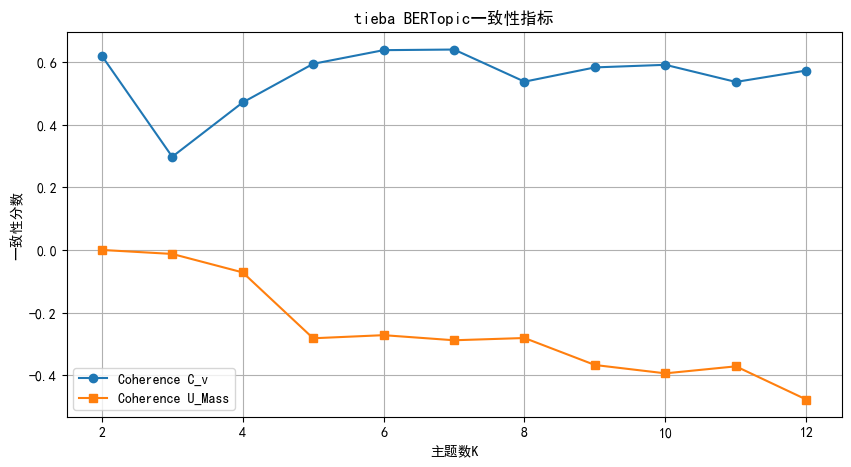


所有平台BERTopic主题建模分析完毕。


In [ ]:
import os
import pandas as pd
import jieba
import re
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt

# --- 参数配置 ---
save_dir = "E:"
platforms = ['dy', 'xhs', 'tieba']
comment_column = 'content'
k_range = range(2, 13)  # 2~12主题

# 中文停用词加载
def load_chinese_stopwords(filepath, custom_list):
    stopwords = set(custom_list)
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip()
                if word:
                    stopwords.add(word)
    except Exception as e:
        print(f"加载停用词出错: {e}")
    return stopwords

STOPWORDS_PATH = "stopwords1893.txt"
custom_stopwords = ["豆包", "DS", "下载", "文心", "百度", "一言", "内容", "东西", "偷笑", "感觉", "真的", "模型", "女套",
                    "男套", "玫瑰", "捂脸", "哈哈", "排位", "正赛", "量子", "男鞋", "雷诺", "男裤", "永久", "哈", "哈哈哈", "哈哈哈哈",]
stop_words = load_chinese_stopwords(STOPWORDS_PATH, custom_stopwords)

# 分词+去停用词
def preprocess_text(text, stop_words_set):
    if not isinstance(text, str):
        return []
    text = re.sub(r"http[s]?://\S+", "", text)
    text = re.sub(r"[^\u4e00-\u9fa5]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    if not text:
        return []
    words = jieba.lcut(text)
    words = [w for w in words if w not in stop_words_set and len(w) > 1]
    return words

# 输出一致性分数表
def print_coherence_table(k_values, cv, umass):
    print("K\tC_v\t\tU_Mass")
    for k, c_v, u_m in zip(k_values, cv, umass):
        c_v_str = f"{c_v:.4f}" if c_v is not None else "None"
        u_m_str = f"{u_m:.4f}" if u_m is not None else "None"
        print(f"{k}\t{c_v_str}\t{u_m_str}")

# BERTopic建模+一致性指标评估
def bertopic_with_coherence(texts, k_values, stop_words, platform_name):
    processed_texts = [" ".join(preprocess_text(text, stop_words)) for text in texts]
    # 嵌入器，推荐支持中文的
    embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

    cv_scores, umass_scores = [], []

    for k in k_values:
        print(f"\n{platform_name}: 正在计算BERTopic主题数={k}")
        try:
            topic_model = BERTopic(
                embedding_model=embedding_model,
                nr_topics=k,
                verbose=False,
                calculate_probabilities=False,
                language="chinese"
            )
            topics, _ = topic_model.fit_transform(processed_texts)
            # 组装每个主题的文档
            topic2docs = {}
            for idx, topic_id in enumerate(topics):
                topic2docs.setdefault(topic_id, []).append(processed_texts[idx])
            # 主题文档按分词切割
            topics_docs = [ [w for doc in docs for w in doc.split()] for tid, docs in sorted(topic2docs.items()) if tid != -1]
            # 计算一致性分数
            dictionary = corpora.Dictionary(topics_docs)
            corpus = [dictionary.doc2bow(text) for text in topics_docs]

            # C_v
            cm_cv = CoherenceModel(topics=topics_docs, texts=topics_docs, dictionary=dictionary, coherence='c_v')
            cv_score = cm_cv.get_coherence()
            cv_scores.append(cv_score)
            # U_Mass
            cm_umass = CoherenceModel(topics=topics_docs, corpus=corpus, dictionary=dictionary, coherence='u_mass')
            umass_score = cm_umass.get_coherence()
            umass_scores.append(umass_score)
            print(f"k={k}: C_v={cv_score:.4f}, U_Mass={umass_score:.4f}")

        except Exception as e:
            print(f"主题数k={k} 计算出错: {e}")
            cv_scores.append(None)
            umass_scores.append(None)
    return cv_scores, umass_scores

# 可视化
def plot_metrics(k_values, cv, umass, platform_name):
    valid = [i for i,(a,b) in enumerate(zip(cv,umass)) if a is not None and b is not None]
    k_valid = [k_values[i] for i in valid]
    cv_valid = [cv[i] for i in valid]
    umass_valid = [umass[i] for i in valid]
    plt.figure(figsize=(10,5))
    plt.plot(k_valid, cv_valid, marker='o', label='Coherence C_v')
    plt.plot(k_valid, umass_valid, marker='s', label='Coherence U_Mass')
    plt.xlabel('主题数K')
    plt.ylabel('一致性分数')
    plt.title(f"{platform_name} BERTopic一致性指标")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    for platform in platforms:
        print(f"\n{'='*20} 开始处理平台: {platform} {'='*20}")
        file_path = os.path.join(save_dir, f"{platform}_combined.csv")
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
            if comment_column not in df.columns:
                print(f"错误: {file_path} 缺少评论列 {comment_column}")
                continue
            df.dropna(subset=[comment_column], inplace=True)
            if df.empty:
                print(f"错误: {file_path} 没有有效数据")
                continue
            texts = df[comment_column].tolist()
        except Exception as e:
            print(f"加载文件出错: {e}")
            continue

        # 计算BERTopic一致性
        cv_scores, umass_scores = bertopic_with_coherence(texts, list(k_range), stop_words, platform)
        print(f"\n平台 {platform} BERTopic一致性得分表：")
        print_coherence_table(list(k_range), cv_scores, umass_scores)
        plot_metrics(list(k_range), cv_scores, umass_scores, platform)

    print("\n所有平台BERTopic主题建模分析完毕。")


In [ ]:
import os
import pandas as pd
import jieba
import re
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import hdbscan

# —— 配置部分 —— #
save_dir = r"E:\统计建模大赛\情感介绍\step4"
os.makedirs(save_dir, exist_ok=True)

platforms = ['dy', 'xhs', 'tieba']
comment_column = 'content'

# 停用词
STOPWORDS_PATH = "stopwords1893.txt"
custom_stopwords = [
    "豆包", "DS", "下载", "文心", "百度", "一言", "内容", "东西",
    "偷笑", "感觉", "真的", "模型", "女套", "男套", "玫瑰", "捂脸",
    "哈哈", "排位", "正赛", "量子", "男鞋", "雷诺", "男裤", "永久",
    "哈", "哈哈哈", "哈哈哈哈",
]

def load_chinese_stopwords(filepath, custom_list):
    stopwords = set(custom_list)
    if os.path.isfile(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                w = line.strip()
                if w:
                    stopwords.add(w)
    else:
        print(f"警告：停用词文件未找到：{filepath}")
    return stopwords

stop_words = load_chinese_stopwords(STOPWORDS_PATH, custom_stopwords)

def preprocess_text(text, stop_words_set):
    if not isinstance(text, str):
        return []
    # 去除 URL
    text = re.sub(r"http[s]?://\S+", "", text)
    # 仅保留中文
    text = re.sub(r"[^\u4e00-\u9fa5]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    if not text:
        return []
    words = jieba.lcut(text)
    return [w for w in words if w not in stop_words_set and len(w) > 1]

def print_bertopic_top_words_with_weight(topic_model, n_words=10):
    topics = topic_model.get_topics()
    print("主题号\t主题关键词（带权重）")
    for tid, words in sorted(topics.items()):
        if tid == -1:  # 畸形主题
            continue
        print(f"{tid}\t" + "、".join(f"{w}({wt:.3f})" for w, wt in words[:n_words]))


# 为每个平台预设最优主题数
best_k_dict = {
    "dy": 5,
    "xhs": 7,
    "tieba": 7
}

# 句向量模型（可根据需要换成更大模型）
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

for platform in platforms:
    print(f"\n{'='*10} 开始处理：{platform} {'='*10}")
    csv_path = os.path.join(save_dir, f"{platform}_combined.csv")
    if not os.path.isfile(csv_path):
        print(f"文件不存在，跳过：{csv_path}")
        continue

    # —— 1. 读取数据
    try:
        df = pd.read_csv(csv_path, encoding='utf-8-sig')
        df.dropna(subset=[comment_column], inplace=True)
    except Exception as e:
        print(f"读取 CSV 出错：{e}")
        continue

    texts = df[comment_column].astype(str).tolist()
    processed_texts = [" ".join(preprocess_text(t, stop_words)) for t in texts]
    if not any(processed_texts):
        print("警告：所有文本预处理后均为空，跳过此平台。")
        continue

    # —— 2. 构造模型
    best_k = best_k_dict.get(platform, None)
    umap_model = UMAP(
        n_neighbors=60,
        min_dist=0.1,
        n_components=2,
        metric='cosine',
        random_state=42,
        set_op_mix_ratio=0.8,
        spread=1.5
    )
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=5,
        min_samples=2,
        metric='euclidean',
        cluster_selection_method='eom',
        cluster_selection_epsilon=0.01
    )
    topic_model = BERTopic(
        embedding_model=embedding_model,
        nr_topics=best_k,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        language="chinese"
    )

    # —— 3. 训练 & 打印主题关键词
    topics, probs = topic_model.fit_transform(processed_texts)
    print_bertopic_top_words_with_weight(topic_model, n_words=10)

        # —— 4. 主题关键词条形图（已保存） —— #
    try:
        fig_bar = topic_model.visualize_barchart(top_n_topics=None, n_words=10)
        fig_bar.update_layout(title=f"{platform.upper()} 主题关键词条形图")
        out_bar = os.path.join(f"{platform}_topic_barchart.html")
        fig_bar.write_html(out_bar)
        print(f"已保存条形图：{out_bar}")
    except Exception as e:
        print(f"条形图生成/保存失败：{e}")

    # —— 5. UMAP 可视化（主题相似度气泡图） —— #
    try:
        fig_umap = topic_model.visualize_topics()
        fig_umap.update_layout(title=f"{platform.upper()} UMAP 降维主题相似度图")
        out_umap = os.path.join(f"{platform}_topic_umap.html")
        fig_umap.write_html(out_umap)
        print(f"已保存 UMAP 可视化：{out_umap}")
    except Exception as e:
        print(f"UMAP 可视化生成/保存失败：{e}")

    # —— 6. 主题关键词关联热力图 —— #
    try:
        fig_heat = topic_model.visualize_heatmap()
        fig_heat.update_layout(title=f"{platform.upper()} 主题关键词关联热力图")
        out_heat = os.path.join(f"{platform}_topic_heatmap.html")
        fig_heat.write_html(out_heat)
        print(f"已保存热力图：{out_heat}")
    except Exception as e:
        print(f"热力图生成/保存失败：{e}")
        
    try:
        hierarchical_topics = topic_model.hierarchical_topics(processed_texts, topics)
        fig_hier = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
        fig_hier.update_layout(title=f"{platform.upper()} 层次主题结构图")
        out_hier = os.path.join(f"{platform}_topic_hierarchy.html")
        fig_hier.write_html(out_hier)
        print(f"已保存层次主题图：{out_hier}")
    except Exception as e:
        print(f"层次主题生成/保存失败：{e}")

    # —— 7. 动态主题（若包含 time 列） —— #
    # —— 动态主题生成 & 保存 —— #
    if 'time' in df.columns:
        try:
            # 1. 转成 pandas datetime
            df['time'] = pd.to_datetime(df['time'], errors='coerce')
            # 重置索引（保证 processed_texts 与 df.index 对齐）
            df = df.reset_index(drop=True)

            # 2. 把 numpy.datetime64 转成 datetime.datetime，并丢掉 NaT
            df['py_time'] = df['time'].dt.to_pydatetime()
            mask = df['py_time'].notna()
            valid_idx = df.index[mask]  # 取所有有效行的索引列表

            # 3. 构造动态主题输入：
            #    docs_dyn、topics_dyn、timestamps 三者长度一致
            docs_dyn      = [processed_texts[i] for i in valid_idx]
            topics_dyn    = [topics[i]           for i in valid_idx]
            timestamps    = [df.loc[i, 'py_time'] for i in valid_idx]

            # 4. 生成 & 可视化
            topics_over_time = topic_model.topics_over_time(
                docs_dyn, topics_dyn, timestamps, nr_bins=20
            )
            fig_t = topic_model.visualize_topics_over_time(topics_over_time)
            fig_t.update_layout(title=f"{platform.upper()} 动态主题模型")

            # 5. 保存 HTML
            out_t = os.path.join(f"{platform}_topics_over_time.html")
            fig_t.write_html(out_t)
            print(f"已保存动态主题图：{out_t}")

        except Exception as e:
            print(f"动态主题生成/保存失败：{e}")
    else:
        print("未检测到 ‘time’ 列，跳过动态主题分析。")


print("\n所有平台主题词提取完毕。")

In [17]:
def print_bertopic_top_words_with_weight(topic_model, n_words=10):
    topics = topic_model.get_topics()
    print("主题号\t主题关键词（带权重）")
    for tid, words in sorted(topics.items()):
        if tid == -1:  # 畸形主题
            continue
        print(f"{tid}\t" + "、".join(f"{w}({wt:.3f})" for w, wt in words[:n_words]))
 
for platform in platforms:
    print(f"\n{'='*10} 开始处理：{platform} {'='*10}")
    csv_path = os.path.join(save_dir, f"{platform}_combined.csv")
    if not os.path.isfile(csv_path):
        print(f"文件不存在，跳过：{csv_path}")
        continue

    # —— 1. 读取数据
    try:
        df = pd.read_csv(csv_path, encoding='utf-8-sig')
        df.dropna(subset=[comment_column], inplace=True)
    except Exception as e:
        print(f"读取 CSV 出错：{e}")
        continue

    texts = df[comment_column].astype(str).tolist()
    processed_texts = [" ".join(preprocess_text(t, stop_words)) for t in texts]
    if not any(processed_texts):
        print("警告：所有文本预处理后均为空，跳过此平台。")
        continue       
    best_k = best_k_dict.get(platform, None)
    umap_model = UMAP(
        n_neighbors=60,
        min_dist=0.1,
        n_components=2,
        metric='cosine',
        random_state=42,
        set_op_mix_ratio=0.8,
        spread=1.5
    )
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=5,
        min_samples=2,
        metric='euclidean',
        cluster_selection_method='eom',
        cluster_selection_epsilon=0.01
    )
    topic_model = BERTopic(
        embedding_model=embedding_model,
        nr_topics=best_k,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        language="chinese"
    )

    # —— 3. 训练 & 打印主题关键词
    topics, probs = topic_model.fit_transform(processed_texts)
    print_bertopic_top_words_with_weight(topic_model, n_words=10)


========== 开始处理：dy ==========
主题号	主题关键词（带权重）
0	免费(0.037)、好用(0.025)、广告(0.025)、收费(0.023)、泪奔(0.021)、比心(0.021)、确实(0.020)、不错(0.019)、回答(0.019)、搜索(0.018)
1	手机(0.475)、苹果(0.446)、合作(0.185)、华为(0.146)、安卓(0.094)、微信(0.087)、三星(0.067)、放弃(0.059)、自带(0.057)、阿里(0.051)
2	减肥(0.412)、健康(0.129)、体重(0.126)、好看(0.110)、糖尿病(0.084)、一米(0.081)、运动(0.079)、快乐(0.069)、很瘦(0.065)、焦虑(0.063)
3	攻击(1.100)、黑客攻击(0.446)、服务器(0.248)、境外(0.149)、进攻(0.149)、免疫(0.149)、外网(0.149)、挨饿(0.149)、一家人(0.142)、遭受(0.137)

========== 开始处理：xhs ==========
主题号	主题关键词（带权重）
0	飞吻(0.017)、思考(0.017)、好用(0.016)、害羞(0.015)、回答(0.015)、失望(0.015)、生成(0.015)、确实(0.015)、免费(0.015)、喜欢(0.014)
1	中文(0.318)、中国(0.283)、英文(0.083)、北京(0.038)、粤语(0.033)、国外(0.032)、生成(0.029)、上海(0.028)、美国(0.027)、我妈(0.027)
2	一键(0.855)、生成(0.588)、按钮(0.493)、点击(0.180)、密钥(0.162)、扣子(0.143)、怎么回事(0.114)、为啥(0.107)、显示(0.093)、你好(0.078)
3	火山(1.094)、引擎(0.666)、满月(0.506)、方舟(0.317)、新月(0.161)、接入(0.127)、字节(0.114)、早就(0.084)、广场(0.083)、懂不懂(0.082)
4	没人用(0.853)、没人(0.742)、在意(0.463)、无人(0.418)、一绝(0.182)、通义(0.146)、天工(0.146)、清言(0.142)、